In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.offline.init_notebook_mode(connected=True)
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from pandas.tseries.offsets import *
%matplotlib inline

C:\Users\Dragon2\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)


# 1.特徴量作る

trainとtestまとめて特徴量作る 

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
compose = pd.concat((train,test),axis=0)
compose = compose.reset_index().copy()
print(train.shape)
print(test.shape)
#print(compose.shape)
#print(compose)

(2101, 6)
(365, 5)


日付関連

In [5]:
compose.loc[:,"timestamp"] = pd.to_datetime(compose.loc[:,"datetime"])
compose.loc[:,"year"] = compose["timestamp"].apply(lambda x:x.year)
compose.loc[:,"month"] = compose["timestamp"].apply(lambda x:x.month)
compose.loc[:,"day"] = compose["timestamp"].apply(lambda x:x.day)
compose.loc[:,"weekday"] = compose["timestamp"].apply(lambda x:x.dayofweek)
compose.loc[:,"elapsed_days"] = compose.loc[:,"timestamp"].apply(lambda x:(x-compose.loc[0,"timestamp"]).days)
print(compose.shape)

(2466, 13)


https://www.jpm.jp/marketdata/　の成約数（datetimeの去年のデータを使うようにする）

In [6]:
period = ["2009b","2010u","2010b","2011u","2011b","2012u","2012b",
          "2013u","2013b","2014u","2014b","2015u","2015b","2016u","2016b"]
tintai_di = [-14.0,-21.6,-10.8,-4.2,10.4,16.6,31.1,4.1,16.8,9.9,24.5,15.8,13.8,14.9,26.3]
baibai_di = [-21.9,-15.8,1.8,6.4,4.7,9.0,17.1,10.9,26.5,21.9,31.4,17.8,18.7,18.6,23.5]

In [7]:
tintai_di_b = []
for i in range(0,len(tintai_di),2):
    tintai_di_b.append(tintai_di[i])
tintai_di_u = []
for i in range(1,len(tintai_di),2):
    tintai_di_u.append(tintai_di[i])
baibai_di_b = []
for i in range(0,len(baibai_di),2):
    baibai_di_b.append(baibai_di[i])
baibai_di_u = []
for i in range(1,len(baibai_di),2):
    baibai_di_u.append(baibai_di[i])
tintai_di_b_cum = pd.Series(tintai_di_b).cumsum()
tintai_di_u_cum = pd.Series(tintai_di_u).cumsum()
baibai_di_u_cum = pd.Series(baibai_di_u).cumsum()
baibai_di_b_cum = pd.Series(baibai_di_b).cumsum()
p_dict ={}
for  (p,t,b) in zip(period,tintai_di,baibai_di):
    p_dict[p] =(t,b)

In [8]:
#p_dict

In [8]:
def period_mapping(datetime):
    if ((pd.to_datetime("2008-10-01")<datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2008b")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009u")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2009b")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010u")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2010b")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011u")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2011b")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012u")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2012b")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013u")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2013b")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014u")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2014b")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015u")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2015b")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016u")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2016b")

In [9]:
compose.loc[:,"period"] = (compose.loc[:,"timestamp"]).apply(lambda x:period_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u


In [10]:
compose.loc[:,"period"] = (compose.loc[:,"timestamp"]).apply(lambda x:period_mapping(x))
#compose.head()

In [11]:
di_tuple = compose.loc[:,"period"].map(p_dict)
compose.loc[:,"tintai_bi"] = di_tuple.map(lambda x:x[0])
compose.loc[:,"baibai_di"] = di_tuple.map(lambda x:x[1])
print(compose.shape)
#compose.head()

(2466, 16)


関東労働力

In [12]:
period1 = ["2010Q1","2010Q2","2010Q3","2010Q4"
          ,"2011Q1","2011Q2","2011Q3","2011Q4" ,"2012Q1","2012Q2","2012Q3","2012Q4"
          ,"2013Q1","2013Q2","2013Q3","2013Q4","2014Q1","2014Q2","2014Q3","2014Q4"
          ,"2015Q1","2015Q2","2015Q3","2015Q4","2016Q1","2016Q2","2016Q3","2016Q4"
          ,"2017Q1","2017Q2","2017Q3","2017Q4","2018Q1"]
ibaragi = [1535,1561,1560,1554,1533,1560,1553,1546,
           1522,1547,1540,1533,1506,1532,1527,1522,
           1503,1536,1534,1528,1505,1533,1530,1523,
           1504,1532,1527,1520,1500,1527,1518,1513,1491]

totigi =  [1060,1089,1079,1069,1058,1083,1072,1064,
           1054,1079,1068,1055,1045,1070,1060,1047,
           1041,1071,1062,1050,1040,1066,1057,1044,
           1037,1064,1055,1042,1034,1061,1049,1037,1029]

gunma =   [1020,1054,1053,1039,1024,1053,1048,1033,
           1017,1043,1045,1028,1010,1036,1039,1022,
           1007,1040,1043,1025,1006,1034,1034,1018,
           1004,1031,1035,1018,1002,1032,1032,1015,997]

saitama =[3778,3860,3904,3875,3820,3872,3889,3870,
          3793,3843,3834,3817,3743,3779,3795,3781,
          3710,3766,3789,3784,3729,3796,3814,3816,
          3776,3842,3849,3864,3803,3848,3874,3893,3832]

tiba = [3265,3327,3320,3284,3270,3324,3319,3291,
       3274,3309,3298,3274,3268,3316,3308,3280,
       3271,3312,3308,3286,3275,3315,3306,3287,
        3282,3324,3312,3292,3294,3339,3342,3326,3306]

tokyo =[7227,7370,7350,7312,7330,7419,7322,7410,
        7460,7529,7323,7385,7402,7506,7407,7345,
        7431,7581,7433,7512,7534,7732,7560,7646,
        7582,7774,7718,7716,7634,7765,7803,7869,7795]

kanagawa =[4804,4792,4778,4739,4769,4798,4780,4763,
          4717,4789,4775,4769,4770,4777,4689,4759,
          4870,4808,4743,4773,4773,4775,4900,4825,
          4784,4816,4870,4797,4908,4973,4944,4897,4946]

total =[22699,23053,23044,22872,22804,23109,22983,22977,
        22837,23139,22883,22861,22744,23016,22825,22756,
        22833,23114,22912,22958,22862,23251,23201,23159,
        22969,23383,23366,23249,23175,23545,23562,23550,23396]

In [13]:
kanto_dict ={}
for  (p,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total) in zip(period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total):
    kanto_dict[p] =(ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total)

In [14]:
def period1_mapping(datetime):
    if ((pd.to_datetime("2009-1-1")<=datetime) & (datetime<=pd.to_datetime("2009-3-31"))):
        return("2009Q1")
    elif ((pd.to_datetime("2009-3-31")<datetime) & (datetime<=pd.to_datetime("2009-6-30"))):
        return("2009Q2")
    elif ((pd.to_datetime("2009-6-30")<datetime) & (datetime<=pd.to_datetime("2009-9-30"))):
        return("2009Q3")
    elif ((pd.to_datetime("2009-9-30")<datetime) & (datetime<=pd.to_datetime("2009-12-31"))):
        return("2009Q4")
    elif ((pd.to_datetime("2010-1-1")<=datetime) & (datetime<=pd.to_datetime("2010-3-31"))):
        return("2010Q1")
    elif ((pd.to_datetime("2010-3-31")<datetime) & (datetime<=pd.to_datetime("2010-6-30"))):
        return("2010Q2")
    elif ((pd.to_datetime("2010-6-30")<datetime) & (datetime<=pd.to_datetime("2010-9-30"))):
        return("2010Q3")
    elif ((pd.to_datetime("2010-9-30")<datetime) & (datetime<=pd.to_datetime("2010-12-31"))):
        return("2010Q4")
    elif ((pd.to_datetime("2011-1-1")<=datetime) & (datetime<=pd.to_datetime("2011-3-31"))):
        return("2011Q1")
    elif ((pd.to_datetime("2011-3-31")<datetime) & (datetime<=pd.to_datetime("2011-6-30"))):
        return("2011Q2")
    elif ((pd.to_datetime("2011-6-30")<datetime) & (datetime<=pd.to_datetime("2011-9-30"))):
        return("2011Q3")
    elif ((pd.to_datetime("2011-9-30")<datetime) & (datetime<=pd.to_datetime("2011-12-31"))):
        return("2011Q4")
    elif ((pd.to_datetime("2012-1-1")<=datetime) & (datetime<=pd.to_datetime("2012-3-31"))):
        return("2012Q1")
    elif ((pd.to_datetime("2012-3-31")<datetime) & (datetime<=pd.to_datetime("2012-6-30"))):
        return("2012Q2")
    elif ((pd.to_datetime("2012-6-30")<datetime) & (datetime<=pd.to_datetime("2012-9-30"))):
        return("2012Q3")
    elif ((pd.to_datetime("2012-9-30")<datetime) & (datetime<=pd.to_datetime("2012-12-31"))):
        return("2012Q4")
    elif ((pd.to_datetime("2013-1-1")<=datetime) & (datetime<=pd.to_datetime("2013-3-31"))):
        return("2013Q1")
    elif ((pd.to_datetime("2013-3-31")<datetime) & (datetime<=pd.to_datetime("2013-6-30"))):
        return("2013Q2")
    elif ((pd.to_datetime("2013-6-30")<datetime) & (datetime<=pd.to_datetime("2013-9-30"))):
        return("2013Q3")
    elif ((pd.to_datetime("2013-9-30")<datetime) & (datetime<=pd.to_datetime("2013-12-31"))):
        return("2013Q4")
    elif ((pd.to_datetime("2014-1-1")<=datetime) & (datetime<=pd.to_datetime("2014-3-31"))):
        return("2014Q1")
    elif ((pd.to_datetime("2014-3-31")<datetime) & (datetime<=pd.to_datetime("2014-6-30"))):
        return("2014Q2")
    elif ((pd.to_datetime("2014-6-30")<datetime) & (datetime<=pd.to_datetime("2014-9-30"))):
        return("2014Q3")
    elif ((pd.to_datetime("2014-9-30")<datetime) & (datetime<=pd.to_datetime("2014-12-31"))):
        return("2014Q4")
    elif ((pd.to_datetime("2015-1-1")<=datetime) & (datetime<=pd.to_datetime("2015-3-31"))):
        return("2015Q1")
    elif ((pd.to_datetime("2015-3-31")<datetime) & (datetime<=pd.to_datetime("2015-6-30"))):
        return("2015Q2")
    elif ((pd.to_datetime("2015-6-30")<datetime) & (datetime<=pd.to_datetime("2015-9-30"))):
        return("2015Q3")
    elif ((pd.to_datetime("2015-9-30")<datetime) & (datetime<=pd.to_datetime("2015-12-31"))):
        return("2015Q4")
    elif ((pd.to_datetime("2016-1-1")<=datetime) & (datetime<=pd.to_datetime("2016-3-31"))):
        return("2016Q1")
    elif ((pd.to_datetime("2016-3-31")<datetime) & (datetime<=pd.to_datetime("2016-6-30"))):
        return("2016Q2")
    elif ((pd.to_datetime("2016-6-30")<datetime) & (datetime<=pd.to_datetime("2016-9-30"))):
        return("2016Q3")
    elif ((pd.to_datetime("2016-9-30")<datetime) & (datetime<=pd.to_datetime("2016-12-31"))):
        return("2016Q4")
    elif ((pd.to_datetime("2017-1-1")<=datetime) & (datetime<=pd.to_datetime("2017-3-31"))):
        return("2017Q1")


In [15]:
compose.loc[:,"period1"] = (compose.loc[:,"timestamp"]).apply(lambda x:period1_mapping(x))
compose.head()

,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3


In [16]:
kanto_ro = compose.loc[:,"period1"].map(kanto_dict)
compose.loc[:,"ibaragi"] = kanto_ro.map(lambda x:x[0])
compose.loc[:,"totigi"] = kanto_ro.map(lambda x:x[1])
compose.loc[:,"gunma"] = kanto_ro.map(lambda x:x[2])
compose.loc[:,"saitama"] = kanto_ro.map(lambda x:x[3])
compose.loc[:,"tiba"] = kanto_ro.map(lambda x:x[4])
compose.loc[:,"tokyo"] = kanto_ro.map(lambda x:x[5])
compose.loc[:,"kanagawa"] = kanto_ro.map(lambda x:x[6])
compose.loc[:,"total"] = kanto_ro.map(lambda x:x[7])

print(compose.shape)


(2466, 25)


In [18]:
#compose.head()

失業率

In [17]:
unemp = pd.read_csv("data2.csv")
print(unemp.shape)
compose=pd.concat([compose,unemp],axis=1)
compose.head()

(2466, 7)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91


In [18]:
imigrant=pd.read_csv("imigrant2.csv")
print(imigrant.shape)
compose=pd.concat([compose,imigrant],axis=1)
compose.head()

(2466, 13)


,index,client,close,datetime,price_am,price_pm,y,timestamp,year,month,day,weekday,elapsed_days,period,tintai_bi,baibai_di,period1,ibaragi,totigi,gunma,saitama,tiba,tokyo,kanagawa,total,date,next,new,total_unemp,men,women,head,date,Saitama_i,Saitama_O,Tiba_i,Tiba_O,Tokyo_i,Tokyo_O,Kanagawa_i,Kanagawa_O,Osaka_i,Osaka_O,Total_i,Total_o
0,0,0,0,2010-07-01,-1,-1,17.0,2010-07-01,2010,7,1,3,0,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/1,270,85,355,225,138,91,2009/7/1,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
1,1,0,0,2010-07-02,-1,-1,18.0,2010-07-02,2010,7,2,4,1,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/2,270,85,355,225,138,91,2009/7/2,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
2,2,0,0,2010-07-03,-1,-1,20.0,2010-07-03,2010,7,3,5,2,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/3,270,85,355,225,138,91,2009/7/3,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
3,3,0,0,2010-07-04,-1,-1,20.0,2010-07-04,2010,7,4,6,3,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/4,270,85,355,225,138,91,2009/7/4,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986
4,4,0,0,2010-07-05,-1,-1,14.0,2010-07-05,2010,7,5,0,4,2010u,-21.6,-15.8,2010Q3,1560,1079,1053,3904,3320,7350,4778,23044,2009/7/5,270,85,355,225,138,91,2009/7/5,12066,5234,10333,4934,31418,12549,17016,6589,18810,11680,89643,40986


出生数

In [21]:
birthdata = pd.read_csv("birthdatakanto.csv")
birthdata = birthdata[["birthibara","birthtochi","birthgun","birthsai","birthchiba","birthtokyo","birthkana"]]

FileNotFoundError: File b'birthdatakanto.csv' does not exist

In [86]:
compose=pd.concat([compose,birthdata],axis=1)
compose.head()

NameError: name 'birthdata' is not defined

時系列のデータ 7日前まで

In [19]:
compose_1 = compose.copy()
compose_1.loc[:,"timestamp"] = compose_1.loc[:,"timestamp"] + DateOffset(days=1)
compose_2 = compose.copy()
compose_2.loc[:,"timestamp"] = compose_2.loc[:,"timestamp"] + DateOffset(days=2)
compose_3 = compose.copy()
compose_3.loc[:,"timestamp"] = compose_3.loc[:,"timestamp"] + DateOffset(days=3)
compose_4 = compose.copy()
compose_4.loc[:,"timestamp"] = compose_4.loc[:,"timestamp"] + DateOffset(days=4)
compose_5 = compose.copy()
compose_5.loc[:,"timestamp"] = compose_5.loc[:,"timestamp"] + DateOffset(days=5)
compose_6 = compose.copy()
compose_6.loc[:,"timestamp"] = compose_6.loc[:,"timestamp"] + DateOffset(days=6)
compose_7 = compose.copy()
compose_7.loc[:,"timestamp"] = compose_7.loc[:,"timestamp"] + DateOffset(days=7)


In [20]:
temp =  pd.merge(compose,compose_1, on ="timestamp", suffixes=("","1"))
temp =  pd.merge(temp,compose_2, on ="timestamp", suffixes=("","2"))
temp =  pd.merge(temp,compose_3, on ="timestamp", suffixes=("","3"))
temp =  pd.merge(temp,compose_4, on ="timestamp", suffixes=("","4"))
temp =  pd.merge(temp,compose_5, on ="timestamp", suffixes=("","5"))
temp =  pd.merge(temp,compose_6, on ="timestamp", suffixes=("","6"))
temp =  pd.merge(temp,compose_7, on ="timestamp", suffixes=("","7"))

In [21]:
compose = temp.copy()
print(compose.shape)

(2459, 353)


In [22]:
compose.to_csv("compose.csv",index=None)

In [23]:
compose.columns

Index(['index', 'client', 'close', 'datetime', 'price_am', 'price_pm', 'y',
       'timestamp', 'year', 'month',
       ...
       'Tiba_i7', 'Tiba_O7', 'Tokyo_i7', 'Tokyo_O7', 'Kanagawa_i7',
       'Kanagawa_O7', 'Osaka_i7', 'Osaka_O7', 'Total_i7', 'Total_o7'],
      dtype='object', length=353)

# 2.モデリング

2014-3-31までのデータをtrain、2015-4-1～2016-3-31をテストとする(本当のテストデータは2016-4-1～2017-3-31）

In [24]:
(compose["timestamp"] >= pd.to_datetime("2015-4-1")) & (compose["timestamp"] < pd.to_datetime("2016-4-1"))

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68      False
69      False
70      False
71    

In [25]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2015-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2015-4-1")) & (compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()

In [26]:
print(train.shape)
print(train.head())
print(train.tail())

(1728, 353)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0      7       0      0  2010-07-08        -1        -1  10.0 2010-07-08   
1      8       0      0  2010-07-09        -1        -1  12.0 2010-07-09   
2      9       0      0  2010-07-10        -1        -1  21.0 2010-07-10   
3     10       0      0  2010-07-11        -1        -1  15.0 2010-07-11   
4     11       0      0  2010-07-12        -1        -1  11.0 2010-07-12   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2010      7    8        3             7  2010u      -21.6      -15.8   
1  2010      7    9        4             8  2010u      -21.6      -15.8   
2  2010      7   10        5             9  2010u      -21.6      -15.8   
3  2010      7   11        6            10  2010u      -21.6      -15.8   
4  2010      7   12        0            11  2010u      -21.6      -15.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  2

      index  client  close    datetime  price_am  price_pm     y  timestamp  \
1723   1730       0      0  2015-03-27         4         4  95.0 2015-03-27   
1724   1731       1      0  2015-03-28         5         5  88.0 2015-03-28   
1725   1732       0      0  2015-03-29         5         4  96.0 2015-03-29   
1726   1733       1      0  2015-03-30         4         3  87.0 2015-03-30   
1727   1734       1      0  2015-03-31         4         3  75.0 2015-03-31   

      year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
1723  2015      3   27        4          1730  2014b       24.5       31.4   
1724  2015      3   28        5          1731  2014b       24.5       31.4   
1725  2015      3   29        6          1732  2014b       24.5       31.4   
1726  2015      3   30        0          1733  2014b       24.5       31.4   
1727  2015      3   31        1          1734  2014b       24.5       31.4   

     period1  ibaragi  totigi  gunma  saitama  tiba  tok

In [27]:
print(test.shape)
print(test.head())
print(test.tail())

(366, 353)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0   1735       1      0  2015-04-01         3         3  61.0 2015-04-01   
1   1736       1      0  2015-04-02         2         2  60.0 2015-04-02   
2   1737       1      0  2015-04-03         2         1  75.0 2015-04-03   
3   1738       1      0  2015-04-04         4         3  86.0 2015-04-04   
4   1739       1      0  2015-04-05         2         2  69.0 2015-04-05   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2015      4    1        2          1735  2015u       15.8       17.8   
1  2015      4    2        3          1736  2015u       15.8       17.8   
2  2015      4    3        4          1737  2015u       15.8       17.8   
3  2015      4    4        5          1738  2015u       15.8       17.8   
4  2015      4    5        6          1739  2015u       15.8       17.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  20

     index  client  close    datetime  price_am  price_pm      y  timestamp  \
361   2096       1      0  2016-03-27         5         4   94.0 2016-03-27   
362   2097       1      0  2016-03-28         4         4   86.0 2016-03-28   
363   2098       1      0  2016-03-29         4         4   98.0 2016-03-29   
364   2099       1      0  2016-03-30         5         4   99.0 2016-03-30   
365   2100       1      0  2016-03-31         5         4  105.0 2016-03-31   

     year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
361  2016      3   27        6          2096  2015b       13.8       18.7   
362  2016      3   28        0          2097  2015b       13.8       18.7   
363  2016      3   29        1          2098  2015b       13.8       18.7   
364  2016      3   30        2          2099  2015b       13.8       18.7   
365  2016      3   31        3          2100  2015b       13.8       18.7   

    period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kan

In [28]:
train.columns

Index(['index', 'client', 'close', 'datetime', 'price_am', 'price_pm', 'y',
       'timestamp', 'year', 'month',
       ...
       'Tiba_i7', 'Tiba_O7', 'Tokyo_i7', 'Tokyo_O7', 'Kanagawa_i7',
       'Kanagawa_O7', 'Osaka_i7', 'Osaka_O7', 'Total_i7', 'Total_o7'],
      dtype='object', length=353)

In [29]:
#ここでモデリングに使う特徴量を選択する
feature_name=['client', 'close', 'price_am',"price_pm",
       'year', 'month', 'day', 'weekday',
              "y1","y2","y3","y4","y5","y6","y7",
              'month1', 'day1', 'weekday1',
            'month2', 'day2', 'weekday2',
              'month3', 'day3', 'weekday3',
               'month4', 'day4', 'weekday4',
               'month5', 'day5', 'weekday5',
              'month6', 'day6', 'weekday6',
              'month7', 'day7', 'weekday7',
              'ibaragi',"gunma","totigi",'saitama','tiba', 'tokyo', 'kanagawa',
              "new","total","men","head"]

In [30]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(1728, 49)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,Total_i,Total_o
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986


In [139]:
#gridsearch 時間かかるのでパラメータ調整したいときのみ実行

xgb_pars = []

MCWlist = [10, 20, 30,40,50]
ETAlist =  [0.05,0.1,0.2,0.3]
CSlist = [0.3,0.5,0.7]
MDlist =  [6,7,8,9,10]
SSlist = [0.5,0.7,0.9]
LAMBDAlist = [0.5,0.6,0.7]

for MCW in MCWlist:

    for ETA in ETAlist:

        for CS in CSlist:

            for MD in MDlist:

                for SS in SSlist:

                    for LAMBDA in LAMBDAlist:

                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 

                                         'colsample_bytree': CS, 'max_depth': MD,

                                         'subsample': SS, 'lambda': LAMBDA, 

                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',

                                         'silent': 1, 'objective': 'reg:linear'})
patterns = len(MCWlist)*len(ETAlist)*len(CSlist)*len(MDlist)*len(SSlist)*len(LAMBDAlist)
print(patterns)

2700


In [31]:
Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=1)
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

In [ ]:
scores =[]
for i in range(len(xgb_pars)):
    res = xgb.cv(xgb_pars[i], dtrain, num_boost_round=1000,early_stopping_rounds=50,
                 nfold=5,metrics={'rmse'}, seed = 0,verbose_eval = None)
    scores.append(res.loc[:,"test-rmse-mean"].min())
    print(i/patterns)

    
print("____________________________________")
print("best score")
print(pd.Series(scores).min())
print("best param")
print(xgb_pars[pd.Series(scores).argmin()])

0.0
0.00037037037037037035
0.0007407407407407407
0.0011111111111111111
0.0014814814814814814
0.001851851851851852
0.0022222222222222222
0.0025925925925925925
0.002962962962962963
0.0033333333333333335


In [32]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6, 'subsample': 0.9, 
            'lambda': 0.6, 'nthread': -1, 
            'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [33]:
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:33.2196	valid-rmse:34.4865
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:20.8206	valid-rmse:21.8217
[20]	train-rmse:13.4485	valid-rmse:14.3727
[30]	train-rmse:9.19376	valid-rmse:10.2492
[40]	train-rmse:6.82496	valid-rmse:8.16639
[50]	train-rmse:5.56338	valid-rmse:7.19763
[60]	train-rmse:4.88809	valid-rmse:6.765
[70]	train-rmse:4.52105	valid-rmse:6.54538
[80]	train-rmse:4.29884	valid-rmse:6.45337
[90]	train-rmse:4.13444	valid-rmse:6.40749
[100]	train-rmse:4.01107	valid-rmse:6.37444
[110]	train-rmse:3.89458	valid-rmse:6.33813
[120]	train-rmse:3.80299	valid-rmse:6.30577
[130]	train-rmse:3.72535	valid-rmse:6.28887
[140]	train-rmse:3.65294	valid-rmse:6.27921
[150]	train-rmse:3.58174	valid-rmse:6.28091
[160]	train-rmse:3.48848	valid-rmse:6.27831
[170]	train-rmse:3.40602	valid-rmse:6.25944
[180]	train-rmse:3.34448	valid-rmse:6.25145
[190]	train-rmse:3.27653	valid-r

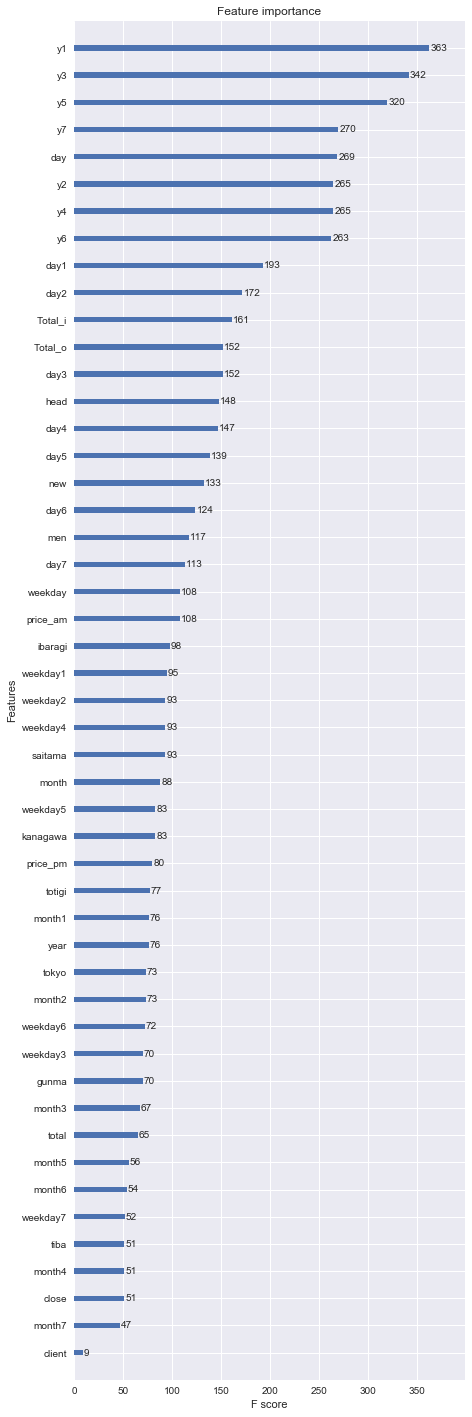

In [34]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

# 3.Predict

In [35]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(1728,)


array([ 11.53821564,  13.55161572,  19.23565865, ...,  79.9342041 ,
        83.11751556,  80.88586426], dtype=float32)

In [36]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(366, 49)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,Total_i,Total_o
0,1,0,3,3,2015,4,1,2,75.0,87.0,96.0,88.0,95.0,85.0,78.0,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,3,25,2,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,112987,141303
1,1,0,2,2,2015,4,2,3,61.0,75.0,87.0,96.0,88.0,95.0,85.0,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,3,26,3,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,112987,141303
2,1,0,2,1,2015,4,3,4,60.0,61.0,75.0,87.0,96.0,88.0,95.0,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,3,27,4,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,112987,141303
3,1,0,4,3,2015,4,4,5,75.0,60.0,61.0,75.0,87.0,96.0,88.0,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,3,28,5,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,112987,141303
4,1,0,2,2,2015,4,5,6,86.0,75.0,60.0,61.0,75.0,87.0,96.0,4,4,5,4,3,4,4,2,3,4,1,2,3,31,1,3,30,0,3,29,6,1533,1034,1066,3796,3315,7732,4775,68,23251,145,54,112987,141303


In [37]:
dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(366,)


array([ 66.984375  ,  52.87664795,  55.7616272 ,  61.22837067,
        64.6120224 ,  66.77031708,  51.78055573,  44.33225632,
        38.85810089,  49.7716217 ,  67.40799713,  66.88339996,
        45.10559845,  45.80988312,  40.38649368,  43.72500992,
        46.25772476,  52.69205093,  48.78695679,  43.24724579,
        34.44337463,  36.56914902,  41.22248459,  54.69421387,
        52.78148651,  53.32650375,  53.05866623,  56.37430573,
        59.39014435,  60.09089661,  49.67434692,  50.16149902,
        40.602211  ,  39.91470718,  35.13499069,  34.35071945,
        33.19869995,  34.13572693,  39.02595901,  36.97169495,
        28.18350792,  24.45280457,  27.29673004,  28.99999046,
        31.64181709,  43.6378746 ,  40.21923828,  29.70414543,
        29.12648964,  29.03831291,  31.77677917,  40.1337471 ,
        49.93576813,  47.63720322,  42.49094772,  40.10261154,
        44.66360092,  44.90235519,  51.35596466,  54.93662643,
        55.38317871,  43.69640732,  28.05706978,  28.74

In [38]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()
te_diviation = test["y"]-test_predict
te_mae = np.absolute(te_diviation).mean()
print("trainデータの予想のMAE =",tr_mae)
print("testデータの予想のMAE =",te_mae)

trainデータの予想のMAE = 2.7402559332894505
testデータの予想のMAE = 7.2770052428454


In [39]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(1728, 2)


,predict,datetime
0,11.538216,2010-07-08
1,13.551616,2010-07-09
2,19.235659,2010-07-10
3,15.042519,2010-07-11
4,12.226164,2010-07-12


In [40]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(366, 2)


,predict,datetime
0,66.984375,2015-04-01
1,52.876648,2015-04-02
2,55.761627,2015-04-03
3,61.228371,2015-04-04
4,64.612022,2015-04-05


In [41]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2094, 2)


,predict,datetime
0,11.538216,2010-07-08
1,13.551616,2010-07-09
2,19.235659,2010-07-10
3,15.042519,2010-07-11
4,12.226164,2010-07-12


In [42]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

# 4.提出

提出は2015-3-31までをtrain,2016-4-1~2017-3-31までをtestとする

In [43]:
train =  compose.loc[(compose["timestamp"] < pd.to_datetime("2016-4-1")),:]
test = compose.loc[(compose["timestamp"] >= pd.to_datetime("2016-4-1")),:]
test = test.reset_index(drop=True).copy()


In [44]:
print(train.shape)
print(train.head())
print(train.tail())

(2094, 353)
   index  client  close    datetime  price_am  price_pm     y  timestamp  \
0      7       0      0  2010-07-08        -1        -1  10.0 2010-07-08   
1      8       0      0  2010-07-09        -1        -1  12.0 2010-07-09   
2      9       0      0  2010-07-10        -1        -1  21.0 2010-07-10   
3     10       0      0  2010-07-11        -1        -1  15.0 2010-07-11   
4     11       0      0  2010-07-12        -1        -1  11.0 2010-07-12   

   year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
0  2010      7    8        3             7  2010u      -21.6      -15.8   
1  2010      7    9        4             8  2010u      -21.6      -15.8   
2  2010      7   10        5             9  2010u      -21.6      -15.8   
3  2010      7   11        6            10  2010u      -21.6      -15.8   
4  2010      7   12        0            11  2010u      -21.6      -15.8   

  period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
0  2

      index  client  close    datetime  price_am  price_pm      y  timestamp  \
2089   2096       1      0  2016-03-27         5         4   94.0 2016-03-27   
2090   2097       1      0  2016-03-28         4         4   86.0 2016-03-28   
2091   2098       1      0  2016-03-29         4         4   98.0 2016-03-29   
2092   2099       1      0  2016-03-30         5         4   99.0 2016-03-30   
2093   2100       1      0  2016-03-31         5         4  105.0 2016-03-31   

      year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
2089  2016      3   27        6          2096  2015b       13.8       18.7   
2090  2016      3   28        0          2097  2015b       13.8       18.7   
2091  2016      3   29        1          2098  2015b       13.8       18.7   
2092  2016      3   30        2          2099  2015b       13.8       18.7   
2093  2016      3   31        3          2100  2015b       13.8       18.7   

     period1  ibaragi  totigi  gunma  saitama  tib

In [45]:
print(test.shape)
print(test.head())
print(test.tail())

(365, 353)
   index  client  close    datetime  price_am  price_pm   y  timestamp  year  \
0      0       1      0  2016-04-01         3         2 NaN 2016-04-01  2016   
1      1       0      0  2016-04-02         5         5 NaN 2016-04-02  2016   
2      2       1      0  2016-04-03         2         2 NaN 2016-04-03  2016   
3      3       1      0  2016-04-04         1         1 NaN 2016-04-04  2016   
4      4       0      0  2016-04-05         1         1 NaN 2016-04-05  2016   

   month  day  weekday  elapsed_days period  tintai_bi  baibai_di period1  \
0      4    1        4          2101  2016u       14.9       18.6  2016Q2   
1      4    2        5          2102  2016u       14.9       18.6  2016Q2   
2      4    3        6          2103  2016u       14.9       18.6  2016Q2   
3      4    4        0          2104  2016u       14.9       18.6  2016Q2   
4      4    5        1          2105  2016u       14.9       18.6  2016Q2   

   ibaragi  totigi  gunma  saitama  tiba  tok

     index  client  close    datetime  price_am  price_pm   y  timestamp  \
360    360       0      0  2017-03-27         5         4 NaN 2017-03-27   
361    361       0      0  2017-03-28         4         4 NaN 2017-03-28   
362    362       0      0  2017-03-29         3         3 NaN 2017-03-29   
363    363       0      0  2017-03-30         4         3 NaN 2017-03-30   
364    364       1      0  2017-03-31         5         4 NaN 2017-03-31   

     year  month  day  weekday  elapsed_days period  tintai_bi  baibai_di  \
360  2017      3   27        0          2461  2016b       26.3       23.5   
361  2017      3   28        1          2462  2016b       26.3       23.5   
362  2017      3   29        2          2463  2016b       26.3       23.5   
363  2017      3   30        3          2464  2016b       26.3       23.5   
364  2017      3   31        4          2465  2016b       26.3       23.5   

    period1  ibaragi  totigi  gunma  saitama  tiba  tokyo  kanagawa  total  \
36

In [46]:
feature = train[feature_name]
y=train["y"]
print(feature.shape)
feature.head()

(2094, 49)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,Total_i,Total_o
0,0,0,-1,-1,2010,7,8,3,4.0,14.0,14.0,20.0,20.0,18.0,17.0,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,7,1,3,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
1,0,0,-1,-1,2010,7,9,4,10.0,4.0,14.0,14.0,20.0,20.0,18.0,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,7,2,4,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
2,0,0,-1,-1,2010,7,10,5,12.0,10.0,4.0,14.0,14.0,20.0,20.0,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,7,3,5,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
3,0,0,-1,-1,2010,7,11,6,21.0,12.0,10.0,4.0,14.0,14.0,20.0,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,7,4,6,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986
4,0,0,-1,-1,2010,7,12,0,15.0,21.0,12.0,10.0,4.0,14.0,14.0,7,11,6,7,10,5,7,9,4,7,8,3,7,7,2,7,6,1,7,5,0,1560,1053,1079,3904,3320,7350,4778,85,23044,225,91,89643,40986


In [47]:
Xtr, Xv, ytr, yv = train_test_split(feature.values, y.values, test_size=0.2, random_state=1)
dtrain = xgb.DMatrix(Xtr, label=ytr, feature_names=feature_name)
dvalid = xgb.DMatrix(Xv, label=yv, feature_names = feature_name)
watchlist = [(dtrain,"train"),(dvalid,"valid")]

xgb_pars = {'min_child_weight': 10, 'eta': 0.05, 'colsample_bytree': 0.3, 'max_depth': 6,
            'subsample': 0.9, 'lambda': 0.7, 'nthread': -1, 'booster': 'gbtree', 
            'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}

In [48]:
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:36.1467	valid-rmse:36.1539
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:22.6027	valid-rmse:22.8823
[20]	train-rmse:14.6306	valid-rmse:15.1873
[30]	train-rmse:10.0089	valid-rmse:10.8936
[40]	train-rmse:7.44138	valid-rmse:8.64769
[50]	train-rmse:6.07934	valid-rmse:7.52676
[60]	train-rmse:5.35077	valid-rmse:7.02814
[70]	train-rmse:4.9378	valid-rmse:6.76644
[80]	train-rmse:4.67289	valid-rmse:6.63089
[90]	train-rmse:4.50761	valid-rmse:6.54364
[100]	train-rmse:4.37204	valid-rmse:6.50457
[110]	train-rmse:4.25362	valid-rmse:6.48365
[120]	train-rmse:4.15723	valid-rmse:6.46
[130]	train-rmse:4.04518	valid-rmse:6.45249
[140]	train-rmse:3.96599	valid-rmse:6.43198
[150]	train-rmse:3.90755	valid-rmse:6.42682
[160]	train-rmse:3.83363	valid-rmse:6.42931
[170]	train-rmse:3.77107	valid-rmse:6.42878
[180]	train-rmse:3.70229	valid-rmse:6.43173
[190]	train-rmse:3.6322	valid-rmse

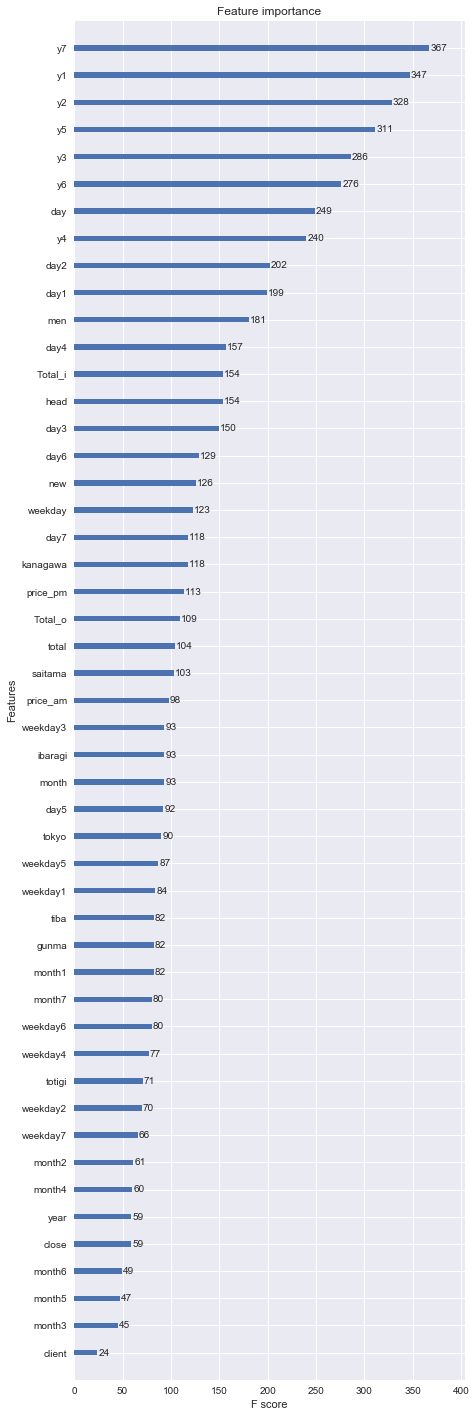

In [49]:
fig, ax = plt.subplots(1,1,figsize=(7,25))
xgb.plot_importance(model,ax=ax)

In [50]:
dfeature = xgb.DMatrix(feature.values, label=y.values, feature_names=feature_name)

train_predict = model.predict(dfeature)
print(train_predict.shape)
train_predict

(2094,)


array([ 11.40515327,  13.38629532,  19.28304482, ...,  91.70594788,
        96.10172272,  97.44150543], dtype=float32)

In [51]:
test_feature = test[feature_name]
test_y=test["y"]
print(test_feature.shape)
test_feature.head()

(365, 49)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,Total_i,Total_o
0,1,0,3,2,2016,4,1,4,105.0,99.0,98.0,86.0,94.0,93.0,90.0,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,3,25,4,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,111227,140358
1,0,0,5,5,2016,4,2,5,NaN,105.0,99.0,98.0,86.0,94.0,93.0,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,3,26,5,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,111227,140358
2,1,0,2,2,2016,4,3,6,NaN,NaN,105.0,99.0,98.0,86.0,94.0,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,3,27,6,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,111227,140358
3,1,0,1,1,2016,4,4,0,NaN,NaN,NaN,105.0,99.0,98.0,86.0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,3,28,0,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,111227,140358
4,0,0,1,1,2016,4,5,1,NaN,NaN,NaN,NaN,105.0,99.0,98.0,4,4,0,4,3,6,4,2,5,4,1,4,3,31,3,3,30,2,3,29,1,1532,1031,1064,3842,3324,7774,4816,63,23383,131,47,111227,140358


In [52]:
def y_predict(feature):
    dtest = xgb.DMatrix(feature.values.reshape((1,-1)), feature_names=feature_name)
    test_predict = model.predict(dtest)
    return(test_predict)

In [53]:
def y_copy(i):
        test_feature.loc[i+1,"y7"] = test_feature.loc[i,"y6"]
        test_feature.loc[i+1,"y6"] = test_feature.loc[i,"y5"]
        test_feature.loc[i+1,"y5"] = test_feature.loc[i,"y4"]
        test_feature.loc[i+1,"y4"] = test_feature.loc[i,"y3"]
        test_feature.loc[i+1,"y3"] = test_feature.loc[i,"y2"]
        test_feature.loc[i+1,"y2"] = test_feature.loc[i,"y1"]
        test_feature.loc[i+1,"y1"] = y_predict(test_feature.loc[i,:])

In [54]:
for i in range(test_feature.shape[0]-1):
    y_copy(i)

C:\Users\Dragon2\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [55]:
print(test_feature.shape)
test_feature.tail()


(365, 49)


,client,close,price_am,price_pm,year,month,day,weekday,y1,y2,y3,y4,y5,y6,y7,month1,day1,weekday1,month2,day2,weekday2,month3,day3,weekday3,month4,day4,weekday4,month5,day5,weekday5,month6,day6,weekday6,month7,day7,weekday7,ibaragi,gunma,totigi,saitama,tiba,tokyo,kanagawa,new,total,men,head,Total_i,Total_o
360,0,0,5,4,2017,3,27,0,90.605675,91.222290,92.696068,94.335632,94.004303,91.474380,95.842934,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,3,21,1,3,20,0,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,141290,166805
361,0,0,4,4,2017,3,28,1,90.524620,90.605675,91.222290,92.696068,94.335632,94.004303,91.474380,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,3,21,1,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,141290,166805
362,0,0,3,3,2017,3,29,2,89.979118,90.524620,90.605675,91.222290,92.696068,94.335632,94.004303,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,3,22,2,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,141290,166805
363,0,0,4,3,2017,3,30,3,92.848190,89.979118,90.524620,90.605675,91.222290,92.696068,94.335632,3,29,2,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,3,23,3,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,141290,166805
364,1,0,5,4,2017,3,31,4,94.014366,92.848190,89.979118,90.524620,90.605675,91.222290,92.696068,3,30,3,3,29,2,3,28,1,3,27,0,3,26,6,3,25,5,3,24,4,1500,1002,1034,3803,3294,7634,4908,62,23175,127,41,141290,166805


In [56]:
dtest = xgb.DMatrix(test_feature.values, label=test_y.values, feature_names=feature_name)
test_predict = model.predict(dtest)
print(test_predict.shape)
test_predict

(365,)


array([ 76.5121994 ,  74.81406403,  73.99814606,  72.16039276,
        68.1230545 ,  64.2463913 ,  62.53068161,  64.30883789,
        69.19587708,  67.04251099,  54.59219742,  46.46952057,
        47.22082901,  47.02742386,  50.39369965,  58.73994446,
        54.86260986,  45.30727768,  41.85250854,  45.09181595,
        45.10121155,  52.93862534,  60.95969772,  59.25034332,
        54.94895554,  49.05073929,  48.79310226,  56.3095932 ,
        61.83401108,  70.62163544,  59.64745331,  41.15500259,
        32.2297287 ,  38.22934341,  34.39905167,  34.10342789,
        43.50630188,  40.86619568,  31.56807709,  28.08362579,
        26.91636276,  32.56483078,  39.65270233,  47.62688446,
        44.09851456,  38.10213089,  30.96389389,  32.27059174,
        36.05315399,  50.04209137,  58.25659561,  54.26635742,
        49.35677719,  46.75413132,  46.18772888,  47.68350601,
        54.2714653 ,  64.04032898,  62.88255692,  55.92023849,
        49.86172104,  44.18647766,  37.26880264,  40.92

In [57]:
tr_diviation = train["y"]-train_predict
tr_mae = np.absolute(tr_diviation).mean()

print("trainデータの予想のMAE =",tr_mae)


trainデータの予想のMAE = 3.030143479648497


In [58]:
tr_predict = pd.DataFrame(train_predict)
tr_predict.loc[:,"datetime"] = train["datetime"]
tr_predict.columns = ["predict","datetime"]
print(tr_predict.shape)
tr_predict.head()

(2094, 2)


,predict,datetime
0,11.405153,2010-07-08
1,13.386295,2010-07-09
2,19.283045,2010-07-10
3,15.337540,2010-07-11
4,11.640235,2010-07-12


In [59]:
te_predict = pd.DataFrame(test_predict)
te_predict.loc[:,"datetime"] = test["datetime"]
te_predict.columns = ["predict","datetime"]
print(te_predict.shape)
te_predict.head()

(365, 2)


,predict,datetime
0,76.512199,2016-04-01
1,74.814064,2016-04-02
2,73.998146,2016-04-03
3,72.160393,2016-04-04
4,68.123055,2016-04-05


In [60]:
predict = pd.concat((tr_predict,te_predict),axis=0)
predict = predict.reset_index(drop=True).copy()
print(predict.shape)
predict.head()

(2459, 2)


,predict,datetime
0,11.405153,2010-07-08
1,13.386295,2010-07-09
2,19.283045,2010-07-10
3,15.337540,2010-07-11
4,11.640235,2010-07-12


In [61]:
plot = go.Scatter( x=compose.datetime, y=compose['y'])
train_plot = go.Scatter( x=tr_predict["datetime"], y=tr_predict["predict"])
test_plot = go.Scatter( x=te_predict["datetime"], y=te_predict["predict"])
data =[plot,train_plot,test_plot]
plotly.offline.iplot(data)

In [63]:
te_predict= te_predict.ix[:,['datetime','predict']]

C:\Users\Dragon2\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [64]:
te_predict.loc[test.loc[:,"close"] ==1,"predict"] =0

In [65]:
te_predict.to_csv("submission.csv",header=None,index=None)